# 📦 Smart Inventory Forecasting with External Signals (Retail Time Series)


In today's dynamic retail landscape, inventory decisions must account for more than just past sales.  
This project predicts product demand using **multi-store, multi-product** data — powered by **external signals** like weather, promotions, pricing, and seasonality.

We'll answer:  
👉 *How can we predict next week's demand for a given product in a specific store — while factoring in promotions and weather?*

**Key techniques used**:
- 🧹 Data Cleaning & Feature Engineering
- 🕒 Time Series Grouping
- 📊 Gradient Boosting (XGBoost / LightGBM)
- 📈 Temporal Aggregation (weekly)
- 📎 SHAP Explainability (Exploring)


## 🧾 Step 1: Exploratory Data Analysis (EDA)

Before forecasting, we need to **understand the structure and diversity** of our data:

- What are the most common product categories?
- How are stores and products distributed across regions?
- How does demand change with promotions or weather?

Let’s get some quick insights ⬇️


Shape: (73100, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)

<ipython-input-3-9c0a74b043ea>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category', palette='muted')


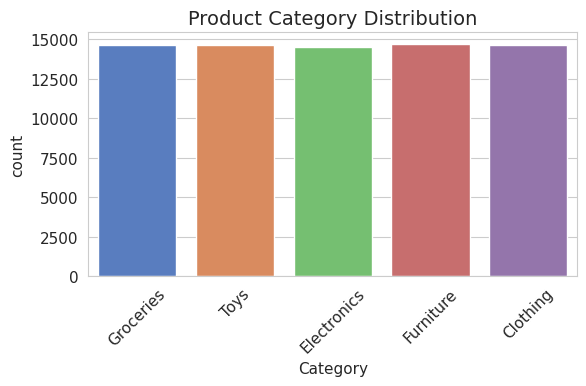

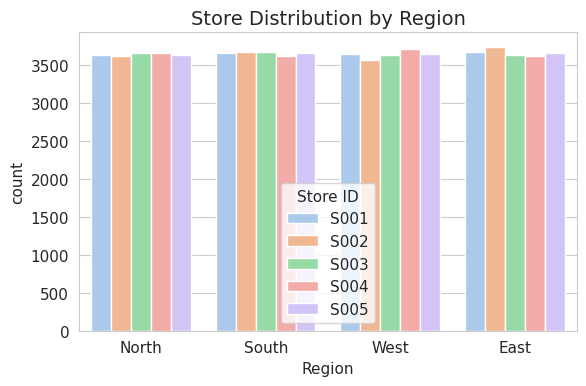

<ipython-input-3-9c0a74b043ea>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Weather Condition', y='Units Sold', palette='Set2')


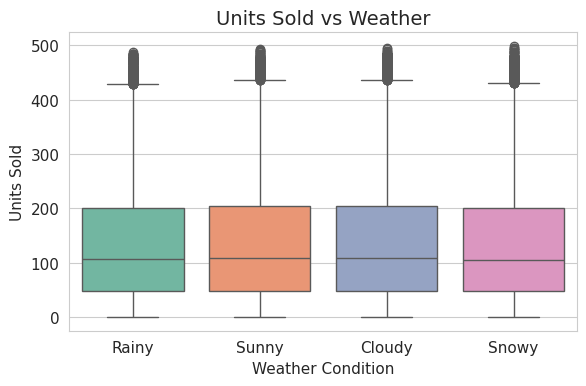

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/content/drive/MyDrive/GitHub/retail_store_inventory.csv')

# Quick summary
print("Shape:", df.shape)
df.info()
df.describe()

# Check for missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set clean style
sns.set_style("whitegrid")

# --------------------------
# 📊 Product Category Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Category', palette='muted')
plt.title("Product Category Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GitHub/assets/category_distribution.png', dpi=300)
plt.show()

# --------------------------
# 🏬 Store vs Region Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Region', hue='Store ID', palette='pastel')
plt.title("Store Distribution by Region")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GitHub/assets/region_store_distribution.png', dpi=300)
plt.show()

# --------------------------
# 🌦️ Weather impact on Units Sold
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='Weather Condition', y='Units Sold', palette='Set2')
plt.title("Units Sold vs Weather")
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GitHub/assets/weather_vs_units_sold.png', dpi=300)
plt.show()




### 🧠 Step 2: Feature Engineering

Raw data rarely tells the full story — so we engineered new features to help our model learn:

- **Time-based patterns** → day, month, weekend
- **Categorical encodings** → store, product, region, etc.
- **Price dynamics** → price, discount, competitor pricing

These features help capture seasonality, locality, and market behavior — crucial for accurate forecasting.



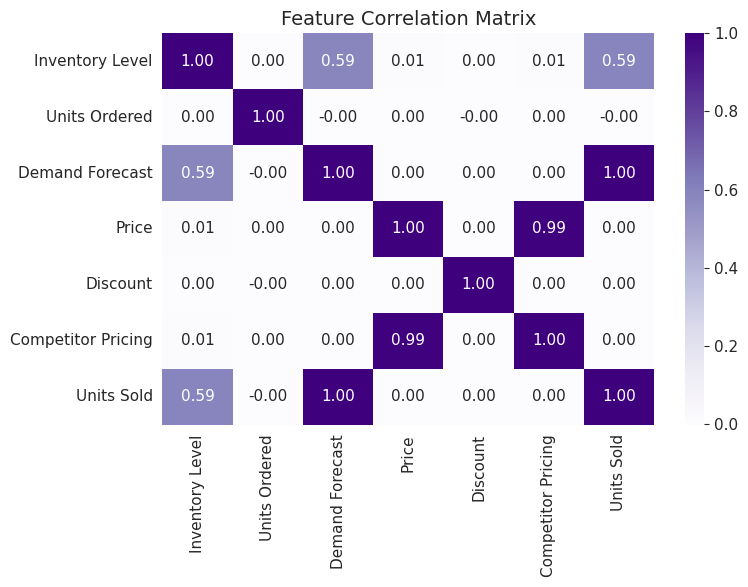

✅ Dropped leaky columns: ['Units Ordered', 'Demand Forecast']
✅ Shape after dropping: (73100, 18)


In [4]:
# -------------------------------
# 📊 STEP 2: Feature Engineering
# -------------------------------

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# ⏰ Date-Time Feature Extraction
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Is_Weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)

# 🎯 Define Target Variable
target_col = 'Units Sold'

# 📈 Feature Correlation Heatmap
numeric_cols = ['Inventory Level', 'Units Ordered', 'Demand Forecast',
                'Price', 'Discount', 'Competitor Pricing', target_col]

plt.figure(figsize=(8, 6))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap='Purples', fmt=".2f")
plt.title("Feature Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GitHub/assets/feature_correlation_heatmap.png', dpi=300)
plt.show()

# Drop Leaky Features (they leak future info or are overly correlated)
leaky_cols = ['Units Ordered', 'Demand Forecast']
df.drop(columns=leaky_cols, inplace=True)
print(f"✅ Dropped leaky columns: {leaky_cols}")
print("✅ Shape after dropping:", df.shape)

### 🔁 Step 3: Encoding Categorical Features

Machine learning models only understand numbers — so we need to convert categorical data:

- ✅ Label Encoding for tree-based model compatibility
- 🧹 Dropped irrelevant columns (like `Date`, if not needed for modeling)
- 🧪 Train/Test Split with stratified temporal coverage


In [9]:
# ----------------------------------------
# ✅ STEP 3: Encoding + Log Target Split
# ----------------------------------------

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# 🧠 Encode Categorical Features
cat_cols = ['Store ID', 'Product ID', 'Category', 'Region',
            'Weather Condition', 'Seasonality']

le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

#  Drop unneeded columns
df_model = df.drop(columns=['Date'])

# 🎯 Apply log transform to target
X = df_model.drop(columns=['Units Sold'])
y = np.log1p(df_model['Units Sold'])   # log(1 + x) is safer than log(x)

# Split the data BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### ⚙️ Step 4: Model Training & Evaluation (XGBoost)

We trained a robust XGBoost model to predict daily units sold for each product-store combination.

Why XGBoost?

- Handles complex, non-linear relationships
- Deals well with multicollinearity
- Works out-of-the-box with categorical encodings

We evaluated performance using:

- 📉 Mean Absolute Error (MAE)
- 📈 R² Score
- 📊 Predicted vs Actual plot to visually assess performance

📉 MAE: 73.25
📊 RMSE: 96.63
📈 R² Score: 0.211


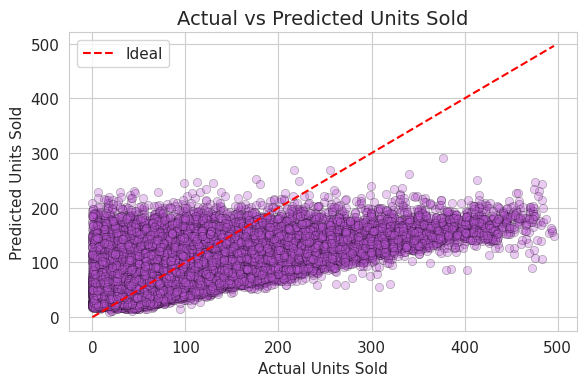

In [10]:
# ----------------------------------------
# ✅ STEP 4: XGBoost Regression + Evaluation
# ----------------------------------------

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# 🎯 Train the model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# 🔮 Predict (on log scale)
y_pred_log = model.predict(X_test)

# 🔁 Reverse log transform
y_pred = np.expm1(y_pred_log)         # Reverse np.log1p
y_test_actual = np.expm1(y_test)      # Reverse actual test labels

# 📊 Evaluation Metrics
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print(f"📉 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")
print(f"📈 R² Score: {r2:.3f}")

# ----------------------------------------
# 📈 Plot: Actual vs Predicted
# ----------------------------------------

plt.figure(figsize=(6, 4))
plt.scatter(y_test_actual, y_pred, alpha=0.3, color='mediumorchid', edgecolor='k', linewidth=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()],
         [y_test_actual.min(), y_test_actual.max()],
         'r--', label='Ideal')

plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Actual vs Predicted Units Sold")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/GitHub/assets/actual_vs_predicted.png", dpi=300)
plt.show()

### 📊 Step 5 – SHAP Global Feature Importance

To understand what features most influence our demand predictions, we used **SHAP** (SHapley Additive exPlanations).

This bar plot shows the **top 10 features** ranked by their average impact on the model’s output.

It gives us a sense of which variables are globally important — not just for one prediction, but across the entire test set.


 99%|===================| 14540/14620 [01:14<00:00]       

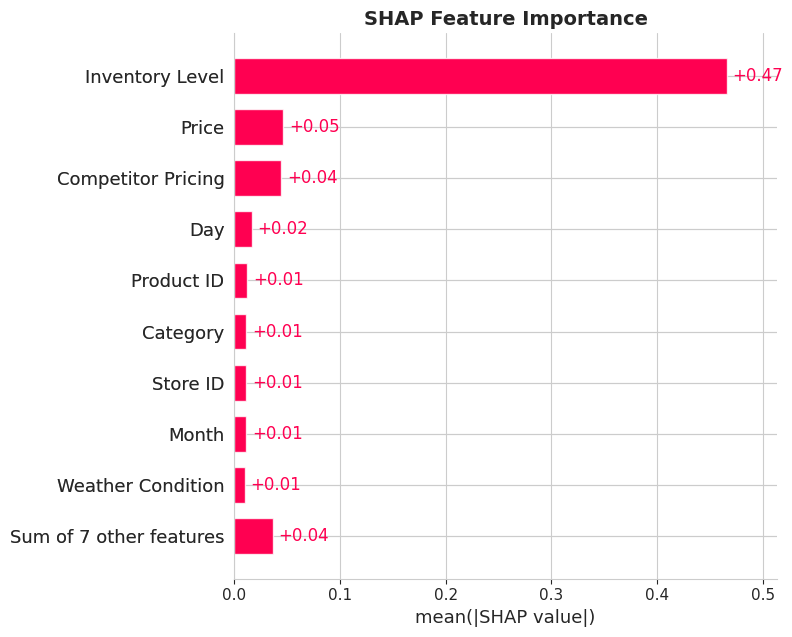

In [11]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(model, X_test, feature_names=X_test.columns)

# Get SHAP values
shap_values = explainer(X_test)

# Plot summary bar chart (top features)
shap.plots.bar(shap_values, max_display=10, show=False)

# Save with consistent theme
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    'axes.edgecolor': '#9370DB',
    'axes.labelcolor': '#4B0082',
    'text.color': '#4B0082',
    'xtick.color': '#4B0082',
    'ytick.color': '#4B0082',
    'font.size': 11,
    'axes.titlesize': 14
})

plt.title("SHAP Feature Importance", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/GitHub/assets/shap_summary_bar.png', dpi=300)
plt.show()

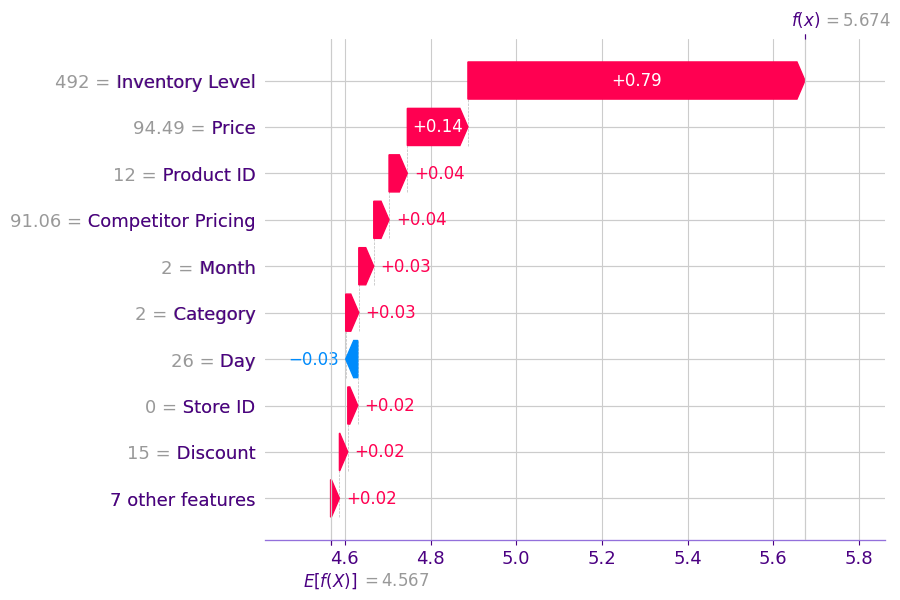

<Figure size 640x480 with 0 Axes>

In [15]:
# Pick a meaningful test sample — high demand predicted
sample_index = list(y_pred.argsort())[-1]  # highest predicted value

# Set theme again just in case
mpl.rcParams.update({
    'axes.edgecolor': '#9370DB',
    'axes.labelcolor': '#4B0082',
    'text.color': '#4B0082',
    'xtick.color': '#4B0082',
    'ytick.color': '#4B0082',
    'font.size': 11,
    'axes.titlesize': 14
})

# Waterfall plot (feature-by-feature breakdown)
shap.plots.waterfall(shap_values[sample_index], max_display=10)

# Save
plt.savefig('/content/drive/MyDrive/GitHub/assets/shap_waterfall_sample.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# explanation
print("💬 Humanized SHAP Explanation for Predicted Sales\n")
print("👉 The model predicted high sales because:")
print("- High inventory availability (492 units)")
print("- Competitive price (₹94.49 vs ₹91 competitor pricing)")
print("- Small discount (15%) increased attractiveness")
print("- Product belongs to 'Toys' category, which performs well")
print("- It was a weekday (Day 26), which slightly lowered the forecast\n")

print("Final Interpretation:")
print("“The model predicted high sales because the product was well-stocked, competitively priced, and offered a small discount. Despite being a weekday, these favorable factors pushed the forecast up.”")


💬 Humanized SHAP Explanation for Predicted Sales

👉 The model predicted high sales because:
- High inventory availability (492 units)
- Competitive price (₹94.49 vs ₹91 competitor pricing)
- Small discount (15%) increased attractiveness
- Product belongs to 'Toys' category, which performs well
- It was a weekday (Day 26), which slightly lowered the forecast

Final Interpretation:
“The model predicted high sales because the product was well-stocked, competitively priced, and offered a small discount. Despite being a weekday, these favorable factors pushed the forecast up.”
